In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

plt.style.use('seaborn-v0_8')
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# patientid (идентификатор пациента);
# age (возраст, есть не для всех записей);
# sex (пол, не для всех записей);
# finding (диагноз: COVID-19, SARS, Pneumonia и другие);
# view (проекция снимка: PA, AP и так далее);
# date (дата исследования).

data = pd.read_csv('input/metadata.csv')
data.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [4]:
data.isnull().sum()

patientid                   0
offset                    253
sex                        80
age                       237
finding                     0
RT_PCR_positive           357
survival                  589
intubated                 702
intubation_present        700
went_icu                  553
in_icu                    615
needed_supplemental_O2    860
extubated                 913
temperature               872
pO2_saturation            831
leukocyte_count           934
neutrophil_count          922
lymphocyte_count          910
view                        0
modality                    0
date                      289
location                   56
folder                      0
filename                    0
doi                       568
url                         0
license                   245
clinical_notes            182
other_notes               514
Unnamed: 29               945
dtype: int64

In [5]:
# удалим ненужные поля
data.drop(columns=['location','doi','url','license','clinical_notes','other_notes','modality','date','view','Unnamed: 29','extubated'], inplace=True)

In [6]:
# Удаляем дубли, оставляя последнюю запись для пациента (по patientid) по max(offset)
sorted_df = data.sort_values(by='offset', ascending=False)
data = sorted_df.drop_duplicates(subset='patientid', keep='first')

# Удаляем значения с диагнозом todo, значит они в процессе лечения и дадут правильных данных
data = data[data['finding']!='todo']

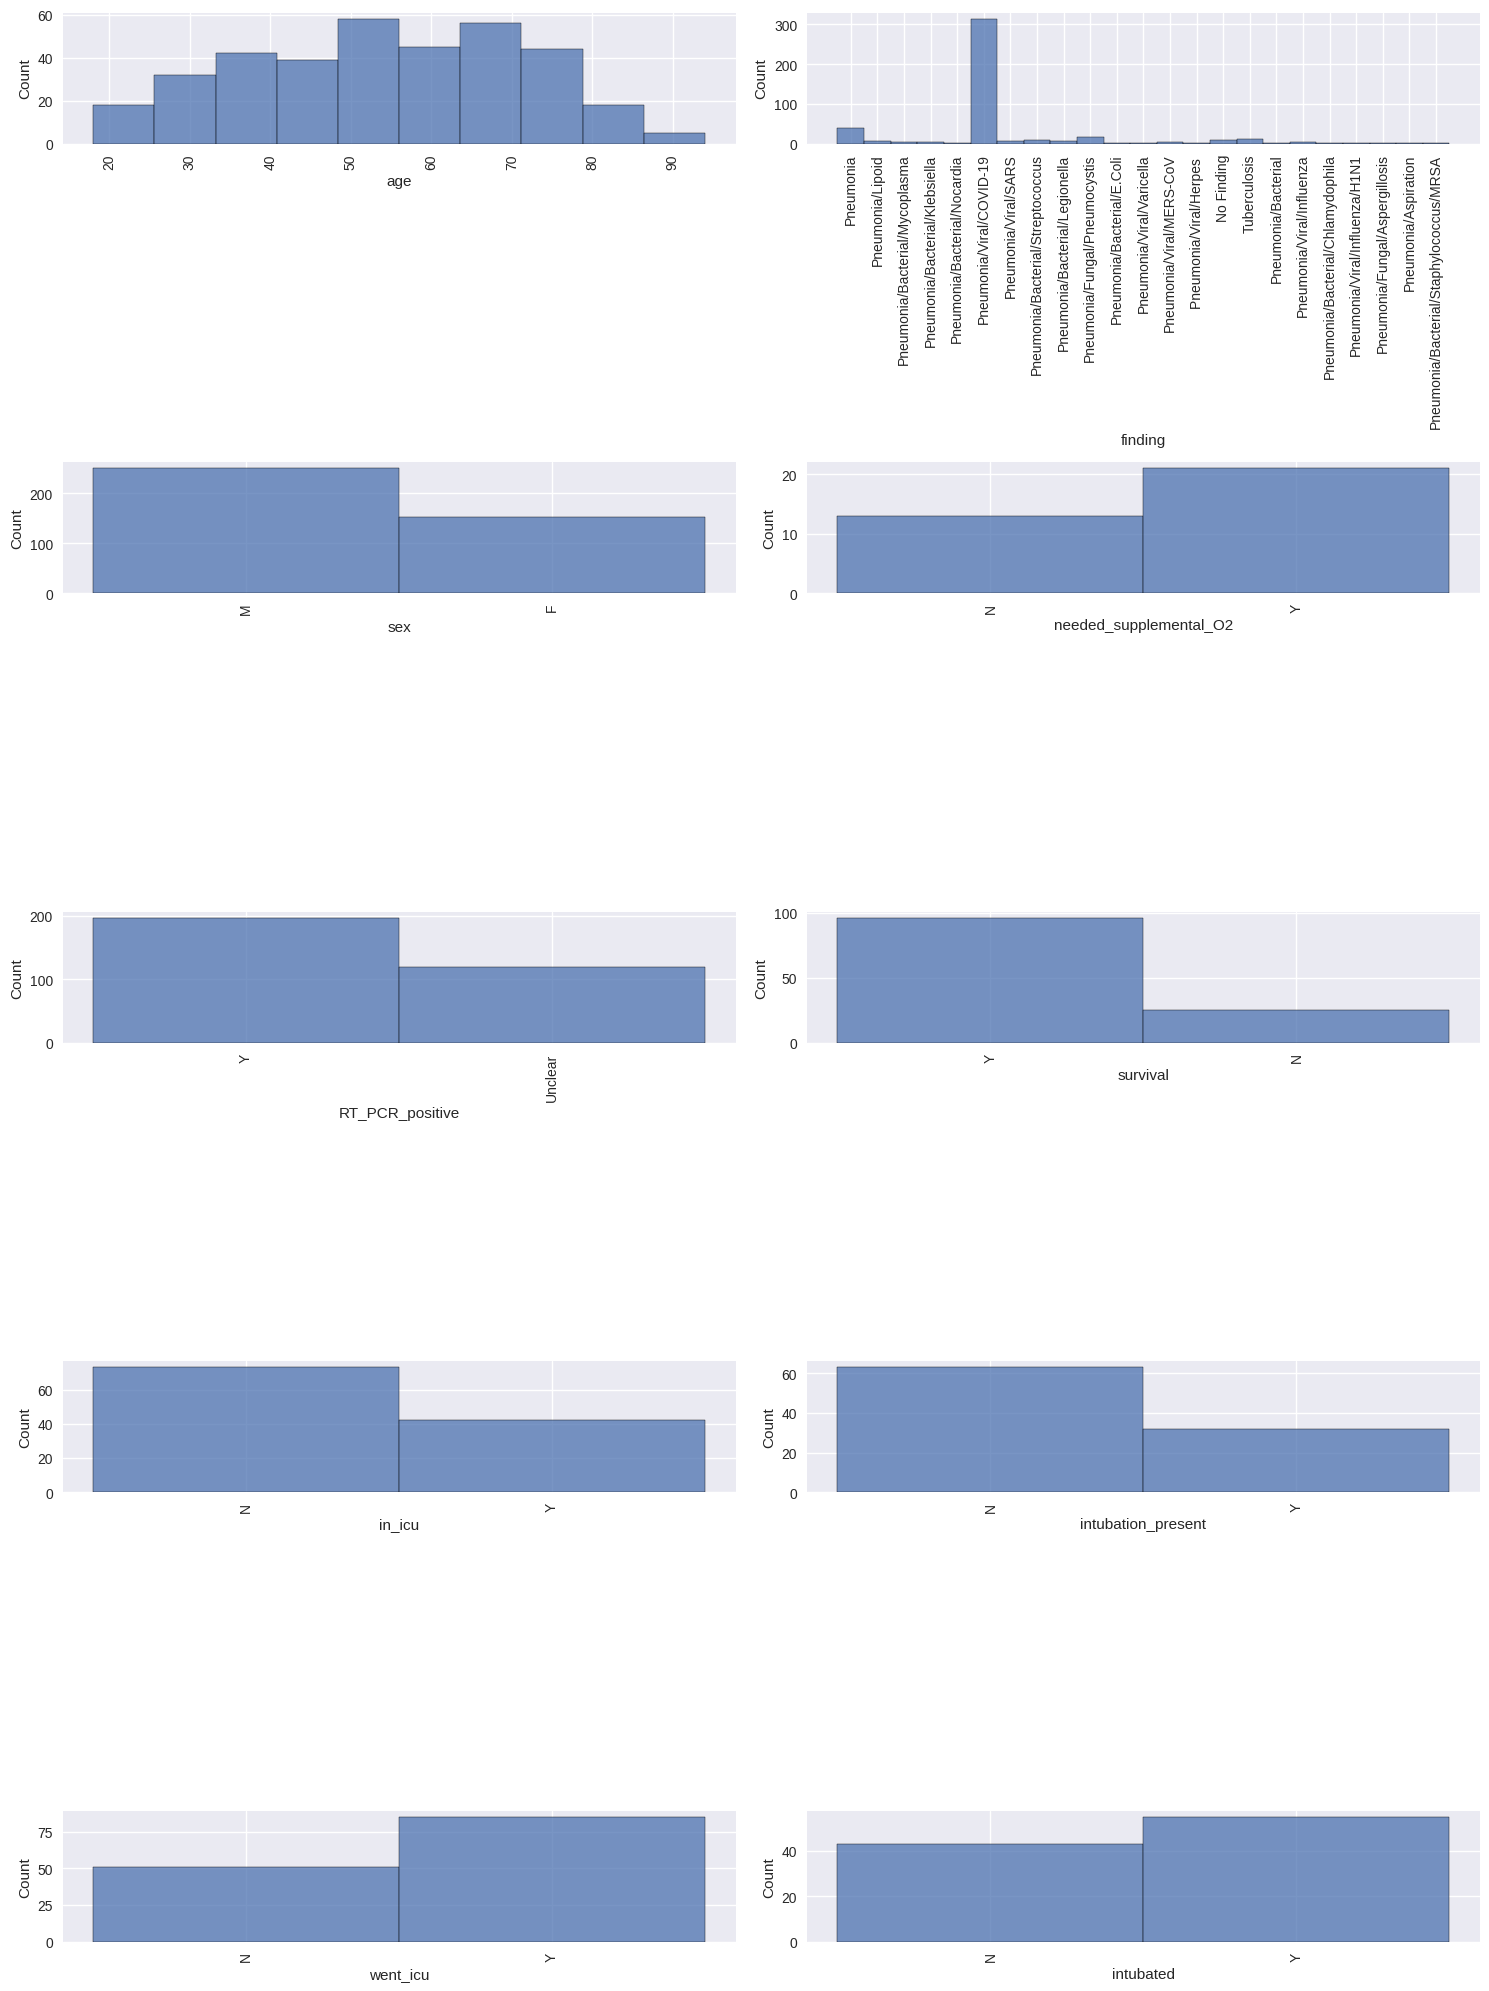

In [7]:
features = ['age','finding','sex', 'needed_supplemental_O2', 'RT_PCR_positive', 'survival', 'in_icu', 'intubation_present', 'went_icu', 'intubated']
def show_features():
    n = len(features)
    fig, axes = plt.subplots(round(n/2), 2, figsize=(15,20))
    for i, feature in enumerate(features):    
        histplot = sns.histplot(data=data, x=feature, ax=axes[int(i/2)][i%2])
        histplot.xaxis.set_tick_params(rotation=90)
    
    plt.tight_layout()

show_features()

<Axes: xlabel='finding', ylabel='count'>

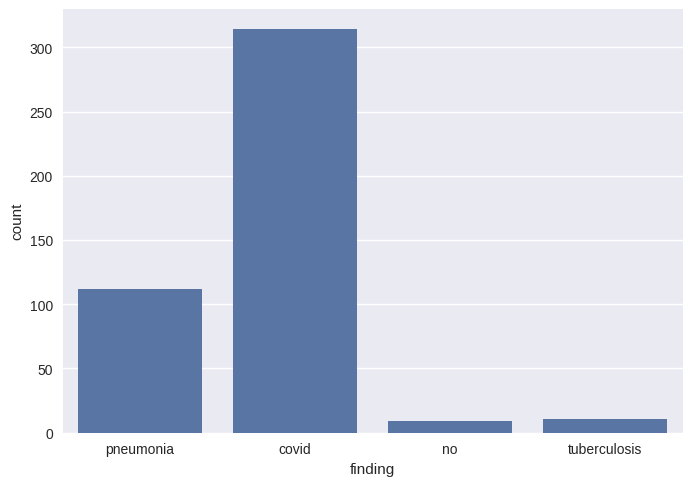

In [8]:
# Укрупляем диагнозы
def func_finding(str):
    if 'COVID' in str:
        return 'covid'
    if 'Pneumonia' in str:
        return 'pneumonia'
    if 'Tuberculosis' in str:
        return 'tuberculosis'
    if 'No Finding' in str:
        return 'no'
    return 'other'

data['finding'] = data['finding'].apply(func_finding)
# Добавляем поле болен или нет
data['sick'] = data['finding'].apply(lambda x: 0 if x == 'No Finding' else 1)

sns.countplot(data=data, x='finding')

In [9]:
# кодируем бинарные категориальные признаки
mapYN = {'Y':1, 'N':0}
mapYUnclear = {'Y':1, 'Unclear':0}
mapMF = {'M':1, 'F':0}


colYN = ['needed_supplemental_O2', 'RT_PCR_positive', 'survival', 'in_icu', 'intubation_present', 'went_icu', 'intubated']
#for f in colYN:
#    data[f] = data[f].map(mapYN)    


data['sex'] = data['sex'].map(mapMF)
data['RT_PCR_positive'] = data['RT_PCR_positive'].map(mapYUnclear)
data['needed_supplemental_O2'] = data['needed_supplemental_O2'].map(mapYN)
data['survival'] = data['survival'].map(mapYN)
data['in_icu'] = data['in_icu'].map(mapYN)
data['intubation_present'] = data['intubation_present'].map(mapYN)
data['went_icu'] = data['went_icu'].map(mapYN)
data['intubated'] = data['intubated'].map(mapYN)

In [10]:
# Заполняем пропуски случайными значениями от 20 до 80, но лучше бы сделать равномерным распределением
data['age'] = data['age'].fillna(random.randint(20,80))

<Axes: xlabel='age_group', ylabel='count'>

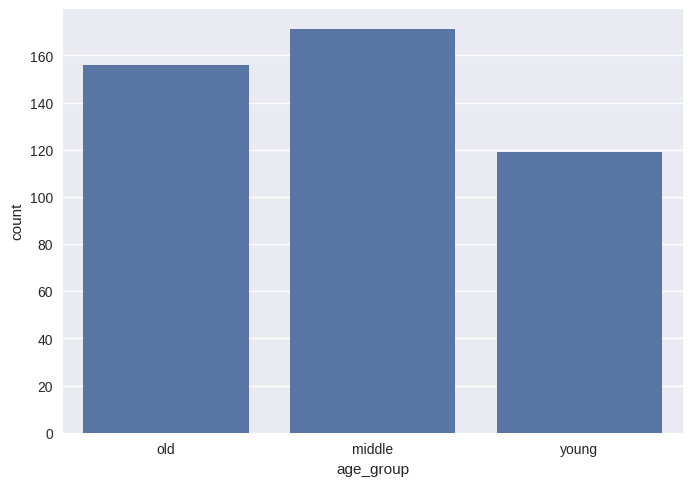

In [12]:
#создаем возрастные группы
def func_agegroup(age):
    if age < 30:
        return 'young'
    elif (age >= 30 and age < 60):
        return 'middle'
    else:
        return 'old'

data['age_group'] = data['age'].apply(func_agegroup)

sns.countplot(data=data, x='age_group')

In [13]:
# изменяем имена папок соглашно укрупненному диагнозу
data['folder'] = data['folder'] + "/" + data['finding']

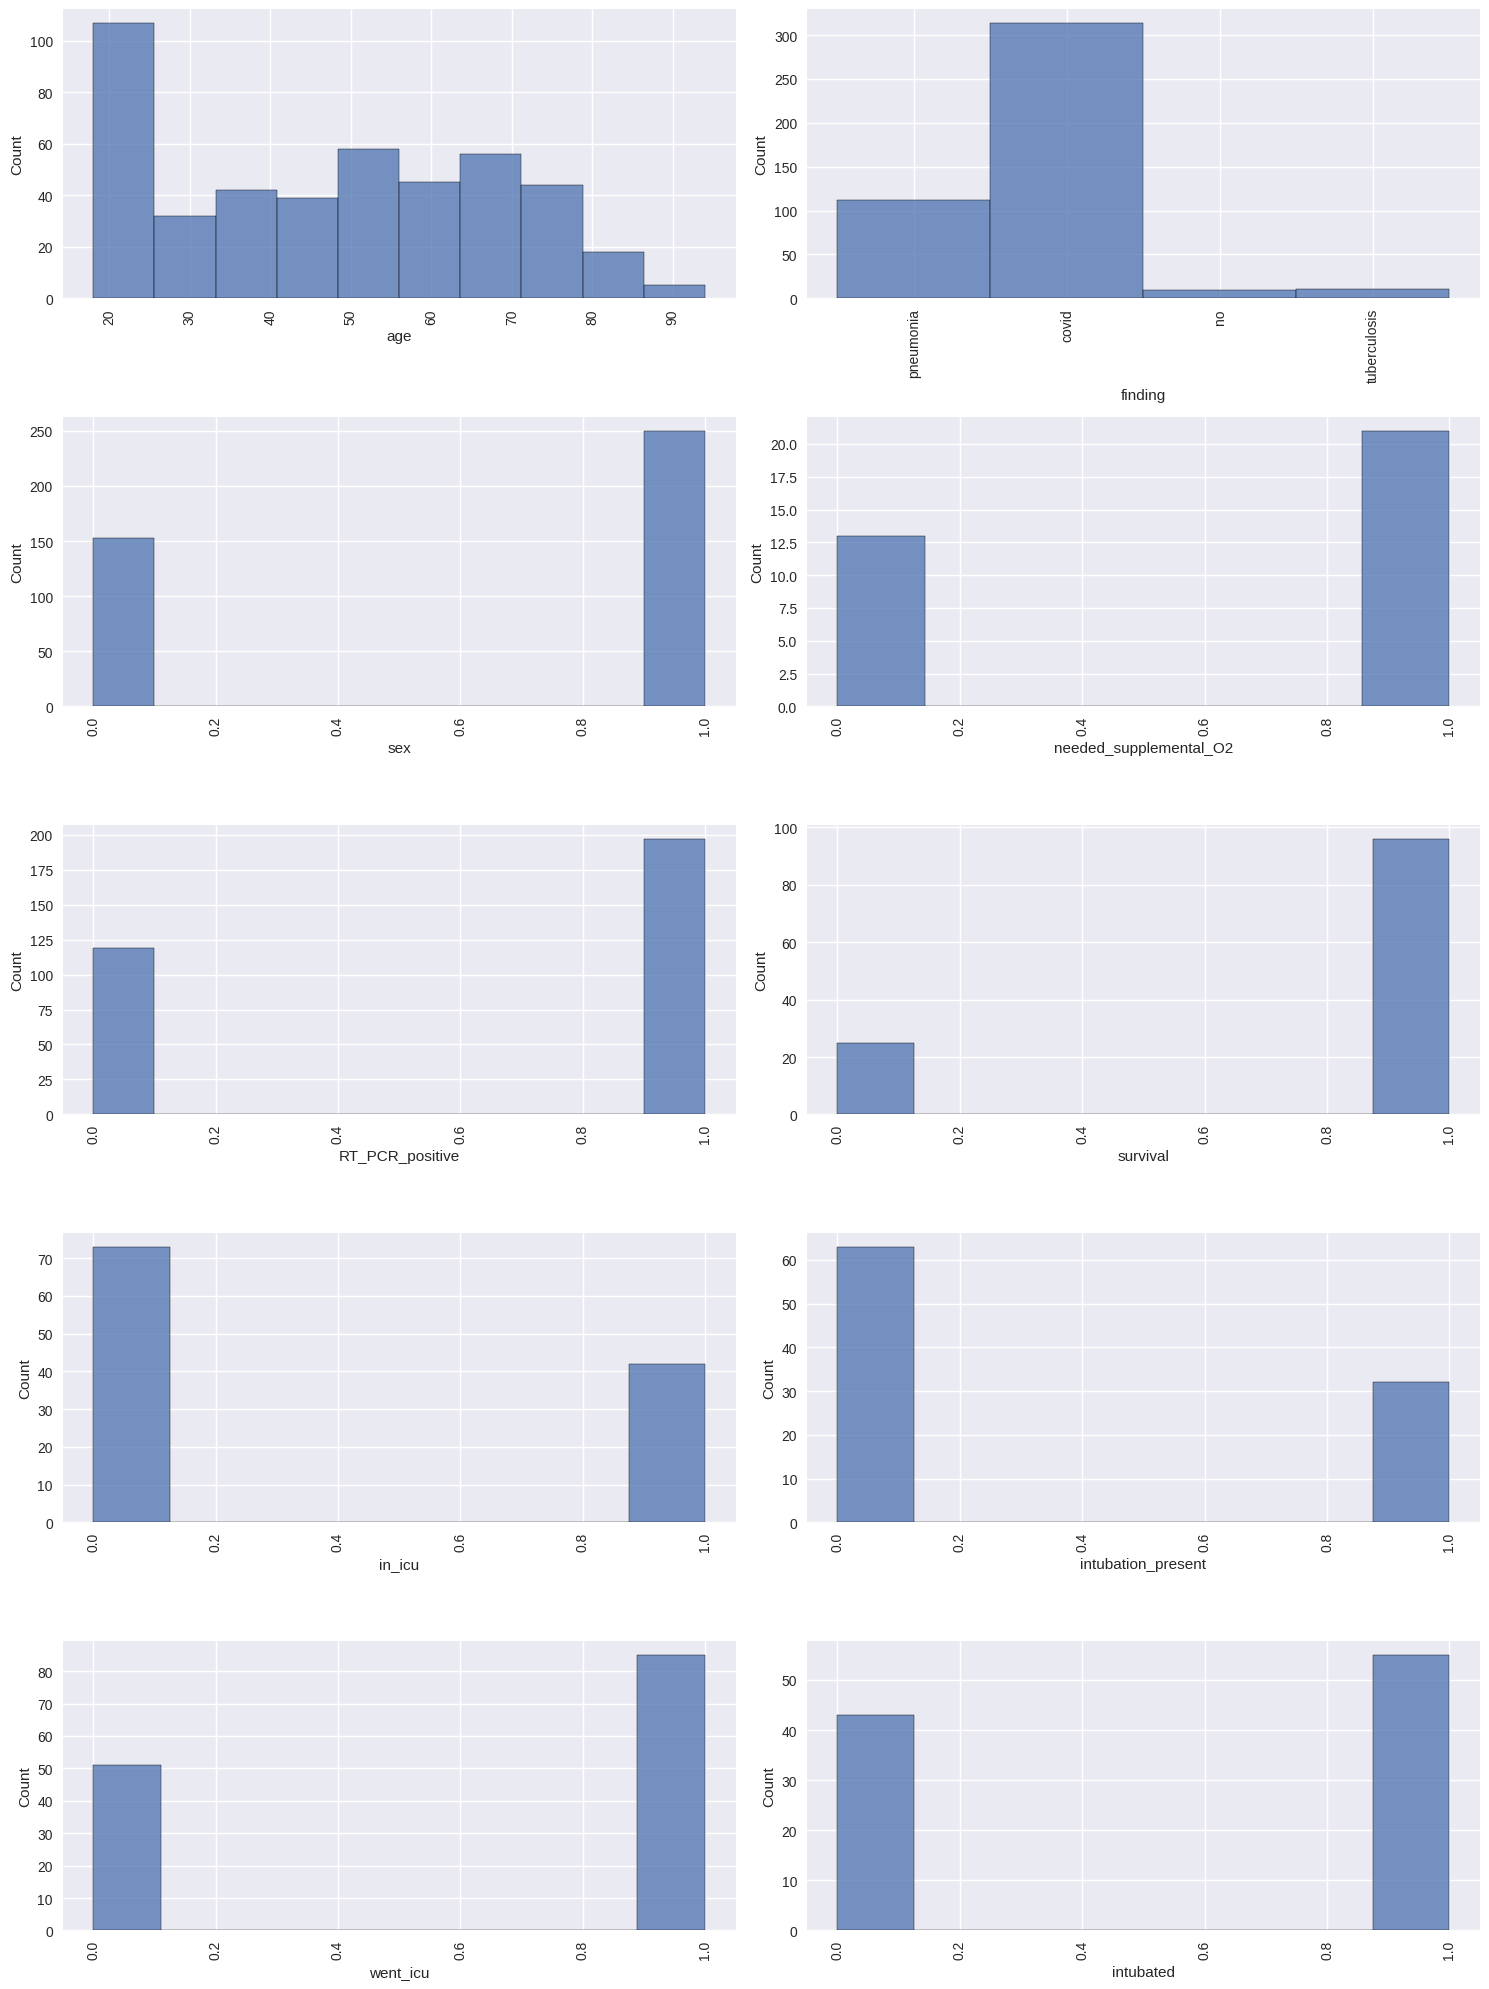

In [14]:
show_features()

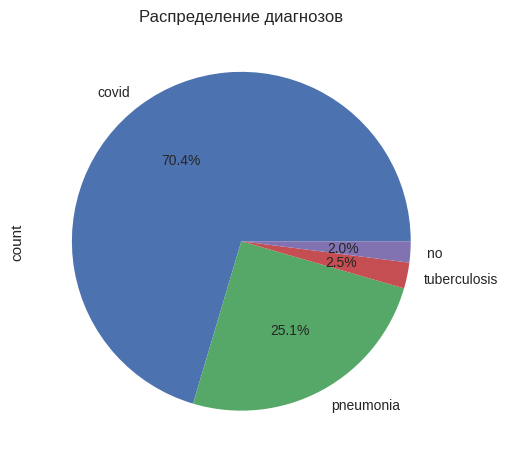

In [15]:
data['finding'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Распределение диагнозов")
plt.show()

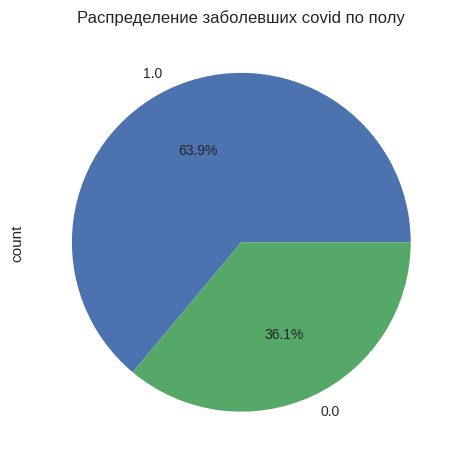

In [16]:
filter_data = data[data['finding']=='covid']
filter_data['sex'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Распределение заболевших covid по полу")
plt.show()

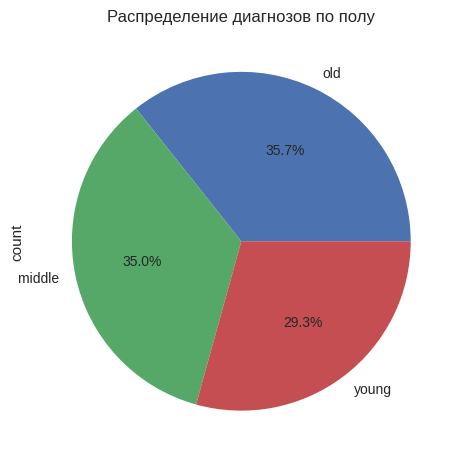

In [17]:
filter_data = data[data['finding']=='covid']
filter_data['age_group'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Распределение диагнозов по полу")
plt.show()

In [18]:
data.to_csv('output/metadata_cleaned.csv')
data.to_parquet('output/metadata.parquet', engine='pyarrow')